# Using Principal Component Analysis to classify handwritten digits
Gonna try to recreate my a simple machine learning (ML) model based of principal component analysis (PCA) to analyze the MNIST dataset and classify unlabelled images of digits. Just finished Linear Algebra and wanna apply one of the labs.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import idx2numpy

plt.rcParams['figure.figsize'] = (6, 3)

Labels: [5 0 4 1 9]


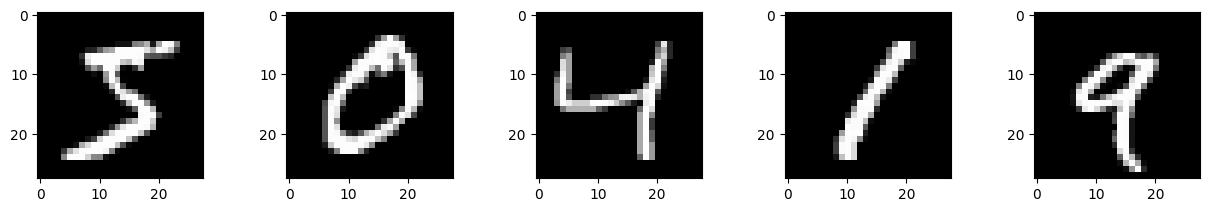

In [2]:
# (60000, 28, 28) images, (60000,) labels
images_2d = idx2numpy.convert_from_file("../data/train-images.idx3-ubyte")
# cover to 2D array (6000, 28 * 28 = 784)
images = images_2d.reshape(images_2d.shape[0], -1)
labels = idx2numpy.convert_from_file("../data/train-labels.idx1-ubyte")

images_shown = 5

print("Labels:", labels[:images_shown])

f, axes = plt.subplots(1, images_shown,
                      figsize=(images_shown * 3, 3),
                      gridspec_kw={'wspace': images_shown/10})
for i, ax in enumerate(axes):
    ax.imshow(images_2d[i], cmap="gray")

## Run PCA on the MNIST images

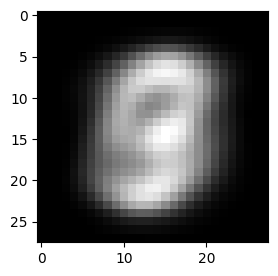

In [3]:
# We need to first center the images so each axias means is zero
# This returns the average image in a 28 x 28 array
mnist_avg = np.average(images, axis=0)
images_shifted = images - mnist_avg

plt.imshow(mnist_avg.reshape((28, 28)), cmap='gray')

In [4]:
# Now that we have the shifted images, we can compute the SVD\
U, S, Vt = la.svd(images_shifted, full_matrices=False)
V = Vt.T

## Apply dimension reduction to PCA

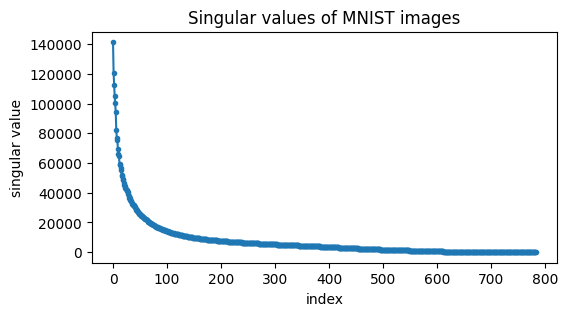

In [5]:
# In this plot we see how the singular values decay
# Showing how the first few singular values capture most of the variance
# These singular values apply a greater weighting to the corresponding singular vectors
plt.plot(S, '.-')
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('Singular values of MNIST images')
plt.show()

(0.0, 50.0)

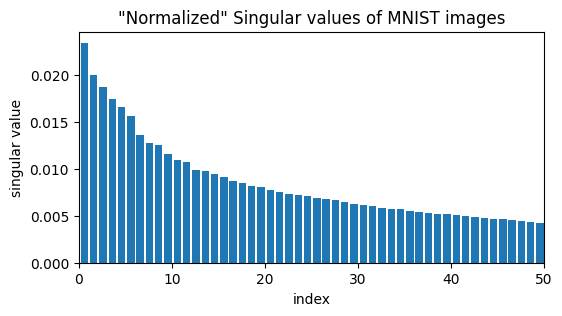

In [6]:
# Normalizing the singular values to show their relative importance
# We see the big difference even in the first 50 singular values
plt.bar(np.arange(len(S)) + .6, S/sum(S))
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('"Normalized" Singular values of MNIST images')
plt.xlim(0,50)

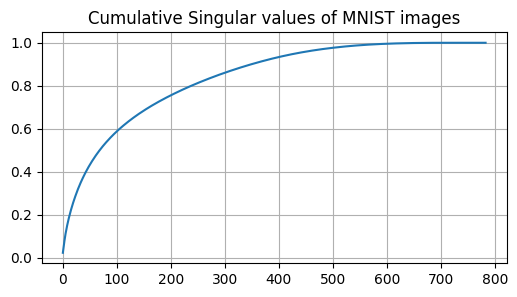

In [7]:
# cum_var is the cumulative sum of the normalized singular values
# Basically the cumulative explained variance - showing how much of the total information is captured as you include more singular values
S_norm = S / np.sum(S)
cum_var = np.cumsum(S_norm)

# This plot shows as we add more singular values, how much of the total variance is captured
# We see how the first 100 singular values capture 60% of the total variance
plt.plot(range(len(S)), cum_var)
plt.title('Cumulative Singular values of MNIST images')
plt.grid()

(0.0, 20.0)

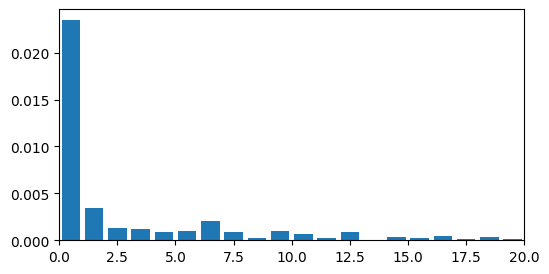

In [8]:
# To find the "kink" in the singular values, we can look for the point where the difference between consecutive singular values increases
# In essence, you want to find the earliest singular value which marks an increased difference from the previous one
# Generally, the (absolute) difference between consecutive singular values should decrease, so identifying the earliest *increase* in these differences will capture any kinks
# like the one we see in the above plot

# This is an array of the difference between consecutive singular values
S_diff = np.append(S_norm[0], np.abs(S_norm[1:] - S_norm[:-1]))
plt.bar(np.arange(len(S)) + .5, S_diff)
plt.xlim(0,20)

In [9]:
# The algorithm is looking for when the rate of decay starts to become irregular
# In a clean exponential decay, each difference should be smaller than the previous one
# But when we hit the "elbow" the singular values stop getting consistently smaller
# And the gaps between them stop getting consistently smaller
# This indicates we've moved past the "important" singular values into the "noise" region

# argmax returns the index of the first occurrence of the maximum value or first true value
reduced_demension = np.argmax(S_diff[1:] - S_diff[:-1] > 0) + 1
# So we cut down from 784 to 5 dimensions
reduced_V = V[:, :reduced_demension]
print(reduced_demension)

5


### Building a nearest-neighbor classifier on MNIST

In [10]:
# Now that we use PCA to reduce the dimensionality of the images, we can project the original images onto the reduced space
# This next part is a simple machine learning algorithm which is K-Nearest Neighbors (KNN)

# Found it weird why we do this order but (n_samples, n_features) @ (n_features, n_components) = (n_samples, n_components)
# This is the projection of the original images onto the reduced principle components space
flat_images_projected = images @ reduced_V

Labels: [7 2 1 0 4]


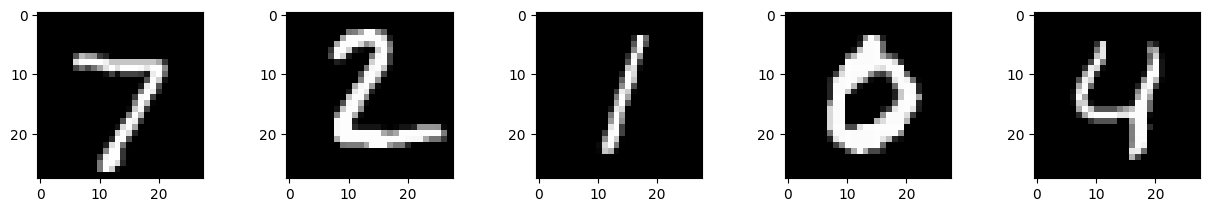

In [11]:
test_images = idx2numpy.convert_from_file("../data/t10k-images.idx3-ubyte")
flat_test_images = test_images.reshape(test_images.shape[0], -1)
test_labels = idx2numpy.convert_from_file("../data/t10k-labels.idx1-ubyte")

test_images_shown = 5

print("Labels:", test_labels[:test_images_shown])

f, axes = plt.subplots(
    1,
    test_images_shown,
    figsize=(test_images_shown * 3, 3),
    gridspec_kw={"wspace": test_images_shown / 10},
)
for i, ax in enumerate(axes):
    ax.imshow(test_images[i], cmap="gray")

In [12]:
image_index = 0
test_projection = (flat_test_images[image_index] - mnist_avg) @ reduced_V
distances = np.linalg.norm(flat_images_projected - test_projection, axis=1)
n = np.argmin(distances)
print(n)

11400


Label: 7


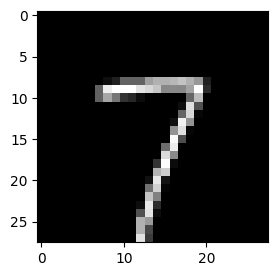

In [13]:
print("Label:", labels[n])
plt.imshow(images[n].reshape((28, 28)), cmap="gray");

### Checks results

In [14]:
flat_test_images_centered = flat_test_images - mnist_avg
test_projections = flat_test_images_centered @ reduced_V

In [15]:
correct_count = 0

for i in range(flat_test_images.shape[0]):
    distances = np.linalg.norm(flat_images_projected - test_projections[i], axis=1)
    n = np.argmin(distances)
    if labels[n] == test_labels[i]:
        correct_count += 1

print(f"Correct Count:{correct_count}")
print(f"Total Test Images:{flat_test_images.shape[0]}")
print(f"Accuracy: {correct_count / flat_test_images.shape[0] * 100:.2f}%")

Correct Count:4495
Total Test Images:10000
Accuracy: 44.95%


## Testing Ideas

### Finding best dimensionality

In [58]:
def dimension_number_classification_accuracy(
    dimensions=reduced_demension, max_train_images=flat_test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    flat_images_projected = images @ reduced_V
    flat_test_images_centered = flat_test_images - mnist_avg
    test_projections = flat_test_images_centered @ reduced_V

    correct_count = 0

    for i in range(max_train_images):
        distances = np.linalg.norm(flat_images_projected - test_projections[i], axis=1)
        n = np.argmin(distances)
        if labels[n] == test_labels[i]:
            correct_count += 1
            
    accuracy = correct_count / max_train_images * 100
    return accuracy, correct_count, max_train_images

In [ ]:
results_data_dim = []
dimensions = [1, 3, reduced_demension, 10, 15, 25, 50, 100]
for dimension in dimensions:
    accuracy, correct, total = dimension_number_classification_accuracy(dimension, 1000)
    results_data_dim.append(
        {
            "Dim": dimension,
            "Accuracy (%)": accuracy,
            "Correct": f"{correct}/{total}",
        }
    )

df_for_dim = pd.DataFrame(results_data_dim)
display(df_for_dim.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

Dim,Accuracy (%),Correct
1,17.50,175/1000
3,30.50,305/1000
5,42.80,428/1000
10,62.30,623/1000
15,71.70,717/1000
25,80.30,803/1000
50,84.20,842/1000
100,84.80,848/1000


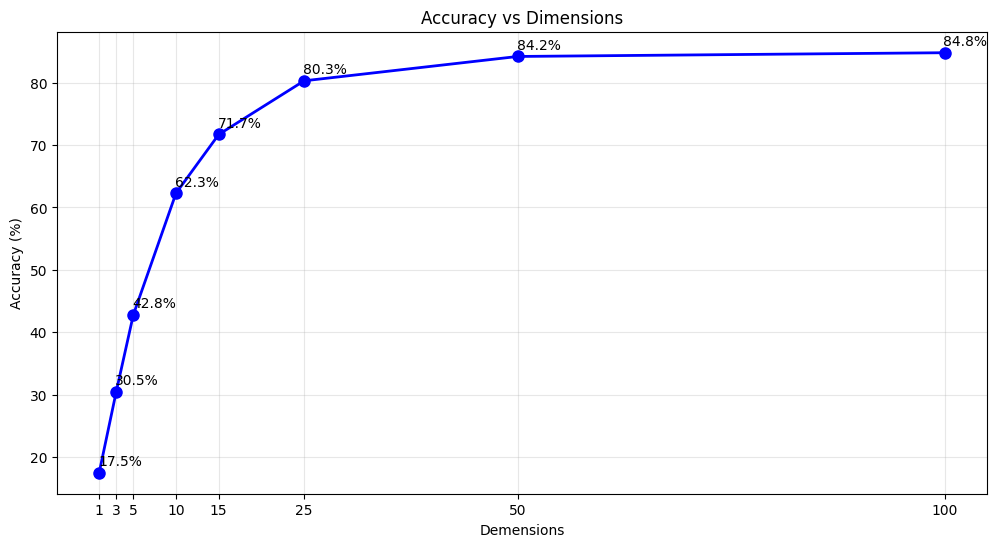

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(
    dimensions, df_for_dim["Accuracy (%)"].values, "bo-", linewidth=2, markersize=8
)
plt.xlabel("Demensions")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Dimensions")
plt.grid(True, alpha=0.3)
plt.xticks(dimensions)
for k, acc in zip(dimensions, df_for_dim["Accuracy (%)"].values):
    plt.annotate(
        f"{acc:.1f}%", (k, acc), textcoords="offset points", xytext=(15, 5), ha="center"
    )
plt.show()

The more dimension I add the better accuracy becomes. Though it does get to a point of diminishing returns. Though going back to previous image where we saw 60% of info is in the first 100 dimension this seems right. Though the "kink" we found at 5 was able to get a good  performance for the tradeof of accuracy.

### Apply proper KNN (K Nearest Neighbors)

In [20]:
# Odd K values can help avoid ties
# Small k values can be more sensitive to noise but captures local patterns
# Larger k values can smooth out the decision boundary but lose details
# I've seen that sqrt(k) is a common heuristic for choosing k

def knn_number_classification_accuracy(
    dimensions=reduced_demension, k=1, max_train_images=flat_test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    flat_images_projected = images @ reduced_V
    flat_test_images_centered = flat_test_images - mnist_avg
    test_projections = flat_test_images_centered @ reduced_V

    correct_count = 0

    for i in range(max_train_images):
        distances = np.linalg.norm(flat_images_projected - test_projections[i], axis=1)
        # Split around pivot but doesn't care about order within the half
        k_nearest_indices = np.argpartition(distances, k)[:k]
        k_nearest_labels = labels[k_nearest_indices]
        # Array with indice showing count of each label
        counts = np.bincount(k_nearest_labels)
        most_repeated_number = np.argmax(counts)
        if most_repeated_number == test_labels[i]:
            correct_count += 1

    accuracy = correct_count / max_train_images * 100
    return accuracy, correct_count, max_train_images

In [ ]:
results_data_k_val = []
k_vals = [1, 3, 5, 7, 9, 13, 17, 21, 27]
for k_val in k_vals:
    accuracy, correct, total = knn_number_classification_accuracy(reduced_demension, k_val, 1000)
    results_data_k_val.append(
        {"k": k_val, "Accuracy (%)": accuracy, "Correct": f"{correct}/{total}"}
    )

df_for_k_vals = pd.DataFrame(results_data_k_val)
display(df_for_k_vals.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

k,Accuracy (%),Correct
1,42.80,428/1000
3,42.40,424/1000
5,41.70,417/1000
7,41.00,410/1000
9,41.10,411/1000
13,41.40,414/1000
17,41.30,413/1000
21,42.50,425/1000
27,41.60,416/1000


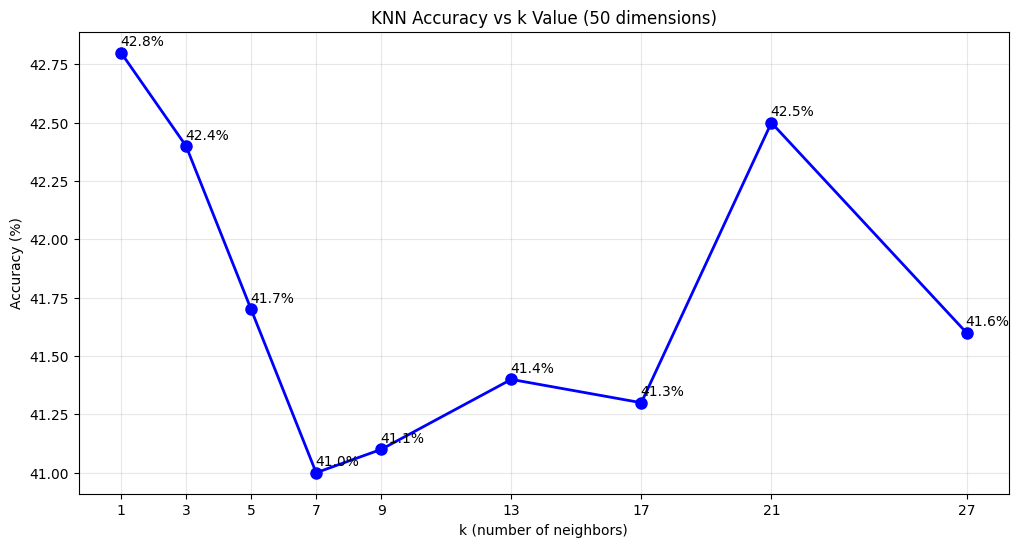

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(k_vals, df_for_k_vals["Accuracy (%)"].values, "bo-", linewidth=2, markersize=8)
plt.xlabel("k (number of neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("KNN Accuracy vs k Value (50 dimensions)")
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)
for k, acc in zip(k_vals, df_for_k_vals["Accuracy (%)"].values):
    plt.annotate(
        f"{acc:.1f}%", (k, acc), textcoords="offset points", xytext=(15, 5), ha="center"
    )
plt.show()

MNIST has high dineionality and the images are very simple where there isn't too much noise and local patterns at a smaller k might be better than having greater k values.

### Switch to a more curve based coordinate system

Just a crazy I had. Basically seeing how frequency could be better moddeled using the DCT coordinate space which is also used for JPEG compression. Maybe by changing to a different coordinate system and then applying SVD to find the orthogonal eigenvectors of this new curve space might be better to preserve more of the curves of the tougher numbers???

There are multiply frequency-domain transforms I've seen. So far I'll try DCT and Fourier.

In [51]:
results_per_num = {
    i: {"Num": i, "Correct": 0, "Total": 0, "Accuracy (%)": 0} for i in range(10)
}

for i in range(flat_test_images.shape[0]):
    distances = np.linalg.norm(flat_images_projected - test_projections[i], axis=1)
    n = np.argmin(distances)
    if labels[n] == test_labels[i]:
        results_per_num[test_labels[i]]["Correct"] += 1
    results_per_num[test_labels[i]]["Total"] += 1

for i in range(10):
    results_per_num[i]["Accuracy (%)"] = (
        results_per_num[i]["Correct"] / results_per_num[i]["Total"] * 100
    )

df_per_num = pd.DataFrame.from_dict(results_per_num, orient="index")
display(df_per_num.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

Num,Correct,Total,Accuracy (%)
0,727,980,74.18
1,1129,1135,99.47
2,542,1032,52.52
3,568,1010,56.24
4,174,982,17.72
5,247,892,27.69
6,268,958,27.97
7,726,1028,70.62
8,38,974,3.90
9,76,1009,7.53


In [57]:
print(df_per_num["Total"].values.sum())
print(df_per_num["Correct"].values.sum())
print(f"Total Accuracy: {df_per_num['Correct'].values.sum() / df_per_num['Total'].values.sum() * 100:.2f}%")
df_per_num_ordered = df_per_num.sort_values(
    by="Accuracy (%)", ascending=False
)
display(df_per_num_ordered.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

10000
4495
Total Accuracy: 44.95%


Num,Correct,Total,Accuracy (%)
1,1129,1135,99.47
0,727,980,74.18
7,726,1028,70.62
3,568,1010,56.24
2,542,1032,52.52
6,268,958,27.97
5,247,892,27.69
4,174,982,17.72
9,76,1009,7.53
8,38,974,3.90


In [60]:
def dimension_number_classification_accuracy(
    dimensions=reduced_demension, max_train_images=flat_test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    flat_images_projected = images @ reduced_V
    flat_test_images_centered = flat_test_images - mnist_avg
    test_projections = flat_test_images_centered @ reduced_V

    results_per_num = {
        i: {"Num": i, "Correct": 0, "Total": 0, "Accuracy (%)": 0} for i in range(10)
    }

    for i in range(max_train_images):
        distances = np.linalg.norm(flat_images_projected - test_projections[i], axis=1)
        n = np.argmin(distances)
        if labels[n] == test_labels[i]:
            results_per_num[test_labels[i]]["Correct"] += 1
        results_per_num[test_labels[i]]["Total"] += 1

    for i in range(10):
        results_per_num[i]["Accuracy (%)"] = (
            results_per_num[i]["Correct"] / results_per_num[i]["Total"] * 100
        )

    df_per_num = pd.DataFrame.from_dict(results_per_num, orient="index")

    return df_per_num

In [62]:
dimensions = [1, 3, reduced_demension, 10, 15, 25, 50, 100]
for dimension in dimensions:
    display(
        dimension_number_classification_accuracy(dimension, 1000).style
        .hide(axis="index")
        .format({"Accuracy (%)": "{:.2f}"})
    )

Num,Correct,Total,Accuracy (%)
0,6,85,7.06
1,126,126,100.00
2,4,116,3.45
3,2,107,1.87
4,7,110,6.36
5,7,87,8.05
6,5,87,5.75
7,6,99,6.06
8,6,89,6.74
9,6,94,6.38


Num,Correct,Total,Accuracy (%)
0,13,85,15.29
1,118,126,93.65
2,31,116,26.72
3,55,107,51.40
4,9,110,8.18
5,3,87,3.45
6,6,87,6.90
7,62,99,62.63
8,4,89,4.49
9,4,94,4.26


Num,Correct,Total,Accuracy (%)
0,55,85,64.71
1,125,126,99.21
2,51,116,43.97
3,61,107,57.01
4,25,110,22.73
5,17,87,19.54
6,18,87,20.69
7,63,99,63.64
8,4,89,4.49
9,9,94,9.57


Num,Correct,Total,Accuracy (%)
0,69,85,81.18
1,126,126,100.00
2,58,116,50.00
3,79,107,73.83
4,72,110,65.45
5,65,87,74.71
6,54,87,62.07
7,65,99,65.66
8,10,89,11.24
9,25,94,26.60


Num,Correct,Total,Accuracy (%)
0,79,85,92.94
1,126,126,100.00
2,73,116,62.93
3,82,107,76.64
4,89,110,80.91
5,68,87,78.16
6,65,87,74.71
7,75,99,75.76
8,20,89,22.47
9,40,94,42.55


Num,Correct,Total,Accuracy (%)
0,81,85,95.29
1,125,126,99.21
2,74,116,63.79
3,90,107,84.11
4,93,110,84.55
5,75,87,86.21
6,78,87,89.66
7,86,99,86.87
8,37,89,41.57
9,64,94,68.09


Num,Correct,Total,Accuracy (%)
0,82,85,96.47
1,125,126,99.21
2,84,116,72.41
3,90,107,84.11
4,94,110,85.45
5,78,87,89.66
6,83,87,95.40
7,88,99,88.89
8,46,89,51.69
9,72,94,76.60


Num,Correct,Total,Accuracy (%)
0,82,85,96.47
1,125,126,99.21
2,83,116,71.55
3,93,107,86.92
4,98,110,89.09
5,77,87,88.51
6,82,87,94.25
7,88,99,88.89
8,48,89,53.93
9,72,94,76.60


In [1]:
dimensions = [1, 3, reduced_demension, 10, 15, 25, 50, 100]
results = {}

for dimension in dimensions:
    _, _, _, df = dimension_number_classification_accuracy(dimension, 1000)
    results[f"{dimension}D"] = df["Accuracy (%)"]

# Combine all results into one DataFrame
combined_df = pd.DataFrame(results)
combined_df.index.name = "Digit"
display(combined_df.style.format("{:.2f}"))

NameError: name 'reduced_demension' is not defined

#### DCT

10000
